Trying to verify the predictions [here](https://ttw-public.notion.site/Datamodels-Per-datapoint-cliff-learning-491c8467f85e4d61be0026c1adb8b1d7).

### Load libraries

In [35]:
import pathlib
import sys
import tempfile
from typing import Any

import git.repo
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import transformers
import wandb
import wandb.apis.public
from tqdm.auto import tqdm
from tqdm.contrib.concurrent import process_map

GIT_ROOT = pathlib.Path(
    str(git.repo.Repo(".", search_parent_directories=True).working_tree_dir)
)
sys.path.append(str(GIT_ROOT))

transformers.logging.set_verbosity_error()

### Load wandb data

In [4]:
api = wandb.Api(timeout=30)
runs: list[wandb.apis.public.Run] = api.runs(
    f"data-frugal-learning/resnet-scaling",
    filters={"tags": {"$in": ["try-2"]}},
)


def get_df_from_run(run_id: str) -> dict[str, Any]:
    api = wandb.Api(timeout=30)
    run = api.run(f"data-frugal-learning/resnet-scaling/{run_id}")

    def flatten_dict(d: dict, prefix: str = "") -> dict:
        ret = dict()
        for k, v in d.items():
            if isinstance(v, dict):
                ret |= flatten_dict(v, prefix=f"{k}_")
            else:
                ret[f"{prefix}{k}"] = v
        return ret

    ret_dict = (
        flatten_dict(run.summary._json_dict)  # type: ignore
        | flatten_dict(run.config)
        | {
            "id": run.id,
            "run_path": "/".join(run.path),
            "name": run.name,
            "state": run.state,
        }
    )
    if run.state != "finished":
        return ret_dict

    # Download per-sample losses
    wf1: wandb.apis.public.File = run.file("per_sample_losses.npy")
    wf2: wandb.apis.public.File = run.file("per_sample_accs.npy")
    with tempfile.TemporaryDirectory() as td:
        with open(wf1.download(root=td).name, "rb") as file:
            ret_dict["per_sample_losses"] = np.load(file)
        with open(wf2.download(root=td).name, "rb") as file:
            ret_dict["per_sample_accs"] = np.load(file)

    return ret_dict

ret_dicts = process_map(
    get_df_from_run,
    [r.id for r in runs],
    max_workers=14,  # https://docs.wandb.ai/guides/track/limits
    tqdm_class=tqdm,
    chunksize=10,
)
df = pd.DataFrame(ret_dicts).query("state == 'finished'")
df["test_err"] = 1 - df.test_acc
df["n_train_cheat"] = df.n_train - df.n_val_override
print(len(df))

  0%|          | 0/1180 [00:00<?, ?it/s]

In [37]:
df_bahri = pd.read_csv(GIT_ROOT / "data/bahri-2021/cifar10/wpd-clean.csv")
df_bahri["loss"] = df_bahri.xent

df_rosenfeld = pd.read_csv(
    GIT_ROOT / "data/rosenfeld-cifar10/wpd-clean.csv"
)

### Basic scaling plots

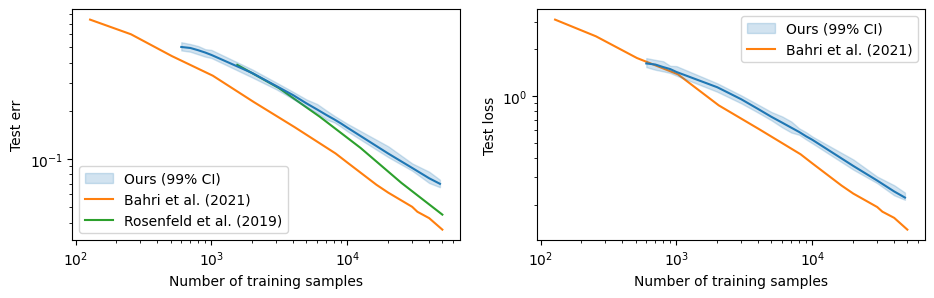

In [44]:
plt.figure(figsize=(11, 3))
for i, target in enumerate(["err", "loss"]):
    plt.subplot(1, 2, i + 1)

    mid = df.groupby("n_train_cheat")[f"test_{target}"].quantile(0.5)
    lo = df.groupby("n_train_cheat")[f"test_{target}"].quantile(0.005)
    hi = df.groupby("n_train_cheat")[f"test_{target}"].quantile(0.995)

    ax = plt.plot(mid.index, mid)
    plt.fill_between(
        mid.index,
        lo,
        hi,
        alpha=0.2,
        label="Ours (99% CI)",
        color=ax[0].get_color(),
    )

    # Reference lines from other papers
    plt.plot(
        df_bahri.n_train,
        df_bahri[target],
        label="Bahri et al. (2021)",
        zorder=-1,
    )
    if target == "err":
        plt.plot(
            df_rosenfeld.n_train,
            df_rosenfeld.err,
            label="Rosenfeld et al. (2019)",
            zorder=-1,
        )

    plt.xscale("log")
    plt.yscale("log")
    plt.xlabel("Number of training samples")
    plt.ylabel(f"Test {target}")
    plt.legend()


### Per sample loss curve

In [33]:
# Aggregate per-sample loss statistics
per_sample_means = np.stack(df.groupby("n_train_cheat").per_sample_losses.mean())  # type: ignore
per_sample_stds = np.stack(
    df.groupby("n_train_cheat").per_sample_losses.agg(
        lambda x: np.stack(x).std(axis=0)
    )  # type: ignore
)

n_trains = df.groupby("n_train_cheat").test_loss.mean().index

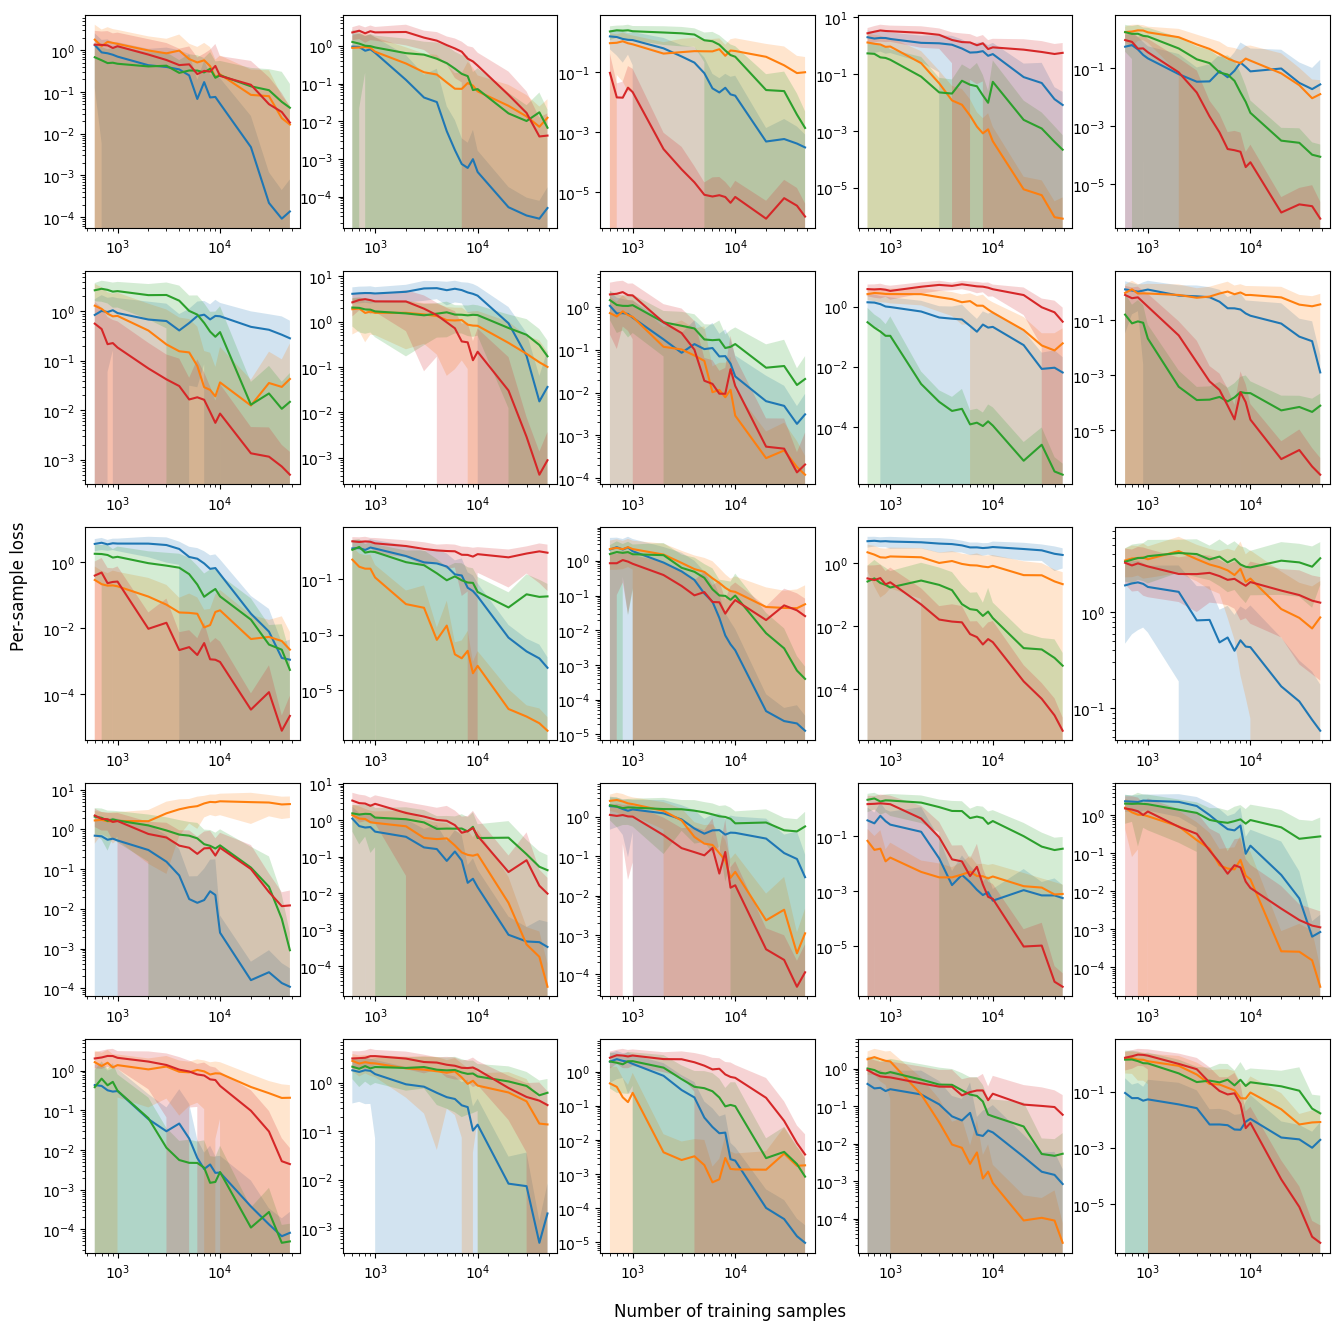

In [49]:
n_rows = 5
n_cols = 5
n_lines_per_plot = 4

fig = plt.figure(figsize=(3 * n_rows, 3 * n_cols))
for i in range(n_rows * n_cols):
    plt.subplot(n_rows, n_cols, i + 1)
    start_idx = i * n_lines_per_plot
    for j in range(n_lines_per_plot):
        plt.plot(
            n_trains,
            per_sample_means[:, start_idx + j],
            label=f"Sample {start_idx + j}",
        )
        plt.fill_between(
            n_trains,
            per_sample_means[:, start_idx + j]
            - per_sample_stds[:, start_idx + j],
            per_sample_means[:, start_idx + j]
            + per_sample_stds[:, start_idx + j],
            alpha=0.2,
        )
    plt.xscale("log")
    plt.yscale("log")

fig.supxlabel("Number of training samples")
fig.supylabel("Per-sample loss")

# Move sup labels closer to subplots
fig.subplots_adjust(
    bottom=0.055,
    left=0.07,
)
fig.show()